# Diabetes Challenge

Your task today is to **analyze** the Kaggle "Pima Indians Diabetes Database" and to **predict** whether a patient has Diabetes or not.

## Task:
- Load the data from the database. The schema is called `diabetes`. To connect to the database you need to copy the `.env` file from the visualization or hands-on-ml repository into this repo. Explore the database, try to establish what the relationships between the tables are (1-1, 1-N, N-M). Explain to yourself and the group what data do you see and whether it makes sense. What JOINs are appropriate to use and why? 
- Use at least two different classification algorithms we have learned so far to predict Diabetes patients. 
- Discuss before you start with the modeling process which **evaluation metric** you choose and explain why.
- Implement a GridSearchCV or RandomizedSearchCV to tune the hyperparameters of your model.
- **Optional:** If you have time at the end, try to use sklearn's pipline module to encapsulate all the steps into a pipeline.

Don't forget to split your data in train and test set. And analyze your final model on the test data. It might also be necessary to scale your data in order to improve the performance of some of the models.


## Helpful links and advise:
- [sklearn documentation on hyperparameter tuning](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)
- It might be helpful to check some sources on how to deal with imbalanced data. 
    * [8 Tactics to Combat Imbalanced Classes](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)
    * [Random-Oversampling/Undersampling](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/)


# Data Description

## Context
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

## Acknowledgements
Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.

## About this dataset
The datasets consist of several medical predictor (independent) variables and one target (dependent) variable, Outcome. Independent variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on. For the outcome class value 1 is interpreted as "tested positive for diabetes".

|Column Name| Description|
|:------------|:------------|
|Pregnancies|Number of times pregnant|
|Glucose|Plasma glucose concentration a 2 hours in an oral glucose tolerance test|
|BloodPressure|Diastolic blood pressure (mm Hg)|
|SkinThickness|Triceps skin fold thickness (mm)|
|Insulin|2-Hour serum insulin (mu U/ml)|
|BMI|Body mass index (weight in kg/(height in m)^2)|
|DiabetesPedigreeFunction|  a function which scores likelihood of diabetes based on family history|
|Age| Age (years)|
|Outcome|Class variable (0 or 1) |

# SQL query to sort 4 databases before CSV export 

SET SCHEMA diabetes;
SELECT
	p.*,
    bm.insulin,
    bm.glucose,
    bm.bloodpressure,
    bm.measurement_date,
    po.diabetespedigreefunction,
    po.outcome,
    s.skinthickness
FROM patient p
LEFT JOIN skin s
	ON p.id = s.patientid
LEFT JOIN blood_metrics bm
	ON p.id = bm.patientid
LEFT JOIN pedigree_outcome po
	ON p.id = po.patientid;

In [13]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the dataset
file_path = 'Day_25_Diabetes_Challenge_data.csv'
df = pd.read_csv(file_path, delimiter=';')

# Show the first few rows of the dataframe to confirm successful loading
df.head()


,id,Age,pregnancies,bmi,insulin,glucose,bloodpressure,measurement_date,diabetespedigreefunction,outcome,skinthickness
0,1,50,6,33.6,0,148,72,2022-12-13,1,1,35
1,2,31,1,26.6,0,85,66,2022-12-13,0,0,29
2,3,32,8,23.3,0,183,64,2022-12-13,1,1,0
3,4,21,1,28.1,94,89,66,2022-12-13,0,0,23
4,5,33,0,43.1,168,137,40,2022-12-13,2,1,35


In [32]:
# Check for missing values
missing_values = df.isnull().sum()

# Check data types of columns
data_types = df.dtypes

# Summary statistics
summary_stats = df.describe()

missing_values, data_types, summary_stats


(id                          0
 Age                         0
 pregnancies                 0
 bmi                         0
 insulin                     0
 glucose                     0
 bloodpressure               0
 measurement_date            0
 diabetespedigreefunction    0
 outcome                     0
 skinthickness               0
 dtype: int64,
 id                            int64
 Age                           int64
 pregnancies                   int64
 bmi                         float64
 insulin                       int64
 glucose                       int64
 bloodpressure                 int64
 measurement_date             object
 diabetespedigreefunction      int64
 outcome                       int64
 skinthickness                 int64
 dtype: object,
                 id          Age  pregnancies          bmi      insulin   
 count  1536.000000  1536.000000  1536.000000  1536.000000  1536.000000  \
 mean    384.500000    33.240885     3.845052    31.992578    64.893229

In [33]:
# Convert 'measurement_date' to datetime format
df['measurement_date'] = pd.to_datetime(df['measurement_date'])

# Check data types again to confirm the conversion
df.dtypes


id                                   int64
Age                                  int64
pregnancies                          int64
bmi                                float64
insulin                              int64
glucose                              int64
bloodpressure                        int64
measurement_date            datetime64[ns]
diabetespedigreefunction             int64
outcome                              int64
skinthickness                        int64
dtype: object

In [34]:
# Columns where 0 is likely to be a placeholder for missing or erroneous data
cols_to_check = ['bmi', 'insulin', 'glucose', 'bloodpressure', 'skinthickness']

# Replace 0 with NaN
df[cols_to_check] = df[cols_to_check].replace(0, np.nan)

# Confirm that zeros have been replaced with NaN
df.head()


,id,Age,pregnancies,bmi,insulin,glucose,bloodpressure,measurement_date,diabetespedigreefunction,outcome,skinthickness
0,1,50,6,33.6,NaN,148.0,72.0,2022-12-13,1,1,35.0
1,2,31,1,26.6,NaN,85.0,66.0,2022-12-13,0,0,29.0
2,3,32,8,23.3,NaN,183.0,64.0,2022-12-13,1,1,NaN
3,4,21,1,28.1,94.0,89.0,66.0,2022-12-13,0,0,23.0
4,5,33,0,43.1,168.0,137.0,40.0,2022-12-13,2,1,35.0


In [35]:
# Impute missing values with the median of each column
for col in cols_to_check:
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)

# Confirm that there are no more NaN values
df.isnull().sum()


id                          0
Age                         0
pregnancies                 0
bmi                         0
insulin                     0
glucose                     0
bloodpressure               0
measurement_date            0
diabetespedigreefunction    0
outcome                     0
skinthickness               0
dtype: int64

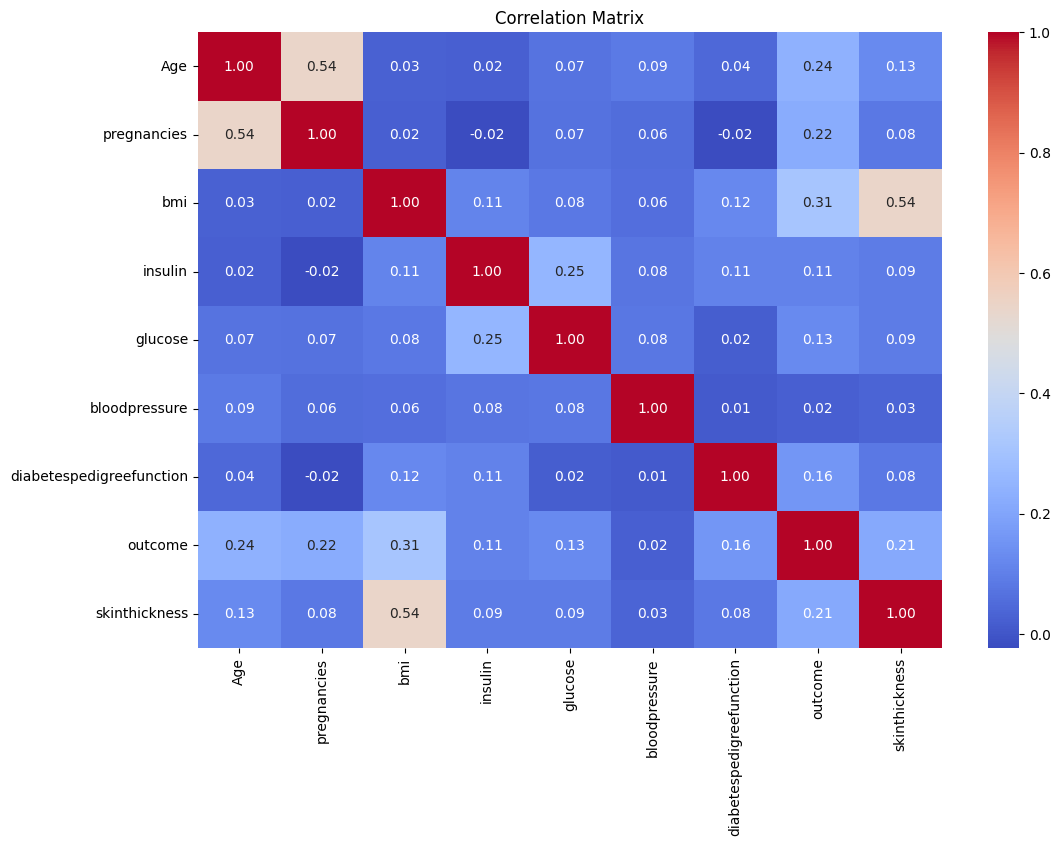

In [36]:
# Drop unnecessary columns for EDA
df.drop(['id', 'measurement_date'], axis=1, inplace=True)

# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [20]:
# Separate features and target variable
X = df.drop('outcome', axis=1)
y = df['outcome']

# Standardize the feature variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Confirm the shape of the split datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1228, 8), (308, 8), (1228,), (308,))

In [21]:
# Initialize and train the Logistic Regression model
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)

# Predict the outcomes for the test set
y_pred_logistic = logistic_model.predict(X_test)

# Calculate the accuracy of the model
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
accuracy_logistic


0.6915584415584416

In [22]:
# Initialize and train the Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)

# Predict the outcomes for the test set
y_pred_decision_tree = decision_tree_model.predict(X_test)

# Calculate the accuracy of the model
accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
accuracy_decision_tree


0.7402597402597403

In [23]:
# Initialize and train the KNN model
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Predict the outcomes for the test set
y_pred_knn = knn_model.predict(X_test)

# Calculate the accuracy of the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_knn


0.672077922077922

In [24]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid for Logistic Regression
param_grid_logistic = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Initialize and perform grid search
grid_search_logistic = GridSearchCV(LogisticRegression(random_state=42), param_grid_logistic, cv=5, scoring='accuracy')
grid_search_logistic.fit(X_train, y_train)

# Get the best parameters and best accuracy score
best_params_logistic = grid_search_logistic.best_params_
best_score_logistic = grid_search_logistic.best_score_

best_params_logistic, best_score_logistic


/Users/eliaen/Spiced_Academy/Day_25_Diabetes_Challenge/ds-diabetes-challenge/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
240 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/eliaen/Spiced_Academy/Day_25_Diabetes_Challenge/ds-diabetes-challenge/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/eliaen/Spiced_Academy/Day_25_Diabetes_Challenge/ds-diabetes-challenge/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit

({'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}, 0.7068159946905591)

In [25]:
# Define hyperparameter grid for Decision Tree
param_grid_decision_tree = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize and perform grid search
grid_search_decision_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_decision_tree, cv=5, scoring='accuracy')
grid_search_decision_tree.fit(X_train, y_train)

# Get the best parameters and best accuracy score
best_params_decision_tree = grid_search_decision_tree.best_params_
best_score_decision_tree = grid_search_decision_tree.best_score_

best_params_decision_tree, best_score_decision_tree


({'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2},
 0.7223228803716608)

In [26]:
# Define hyperparameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'p': [1, 2]
}

# Initialize and perform grid search
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)

# Get the best parameters and best accuracy score
best_params_knn = grid_search_knn.best_params_
best_score_knn = grid_search_knn.best_score_

best_params_knn, best_score_knn


({'n_neighbors': 9, 'p': 1}, 0.7386162269785964)

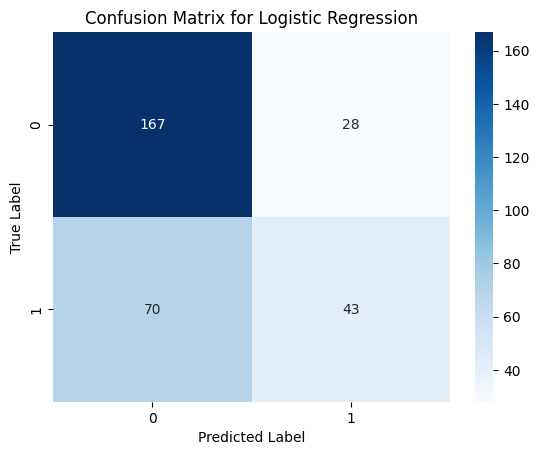

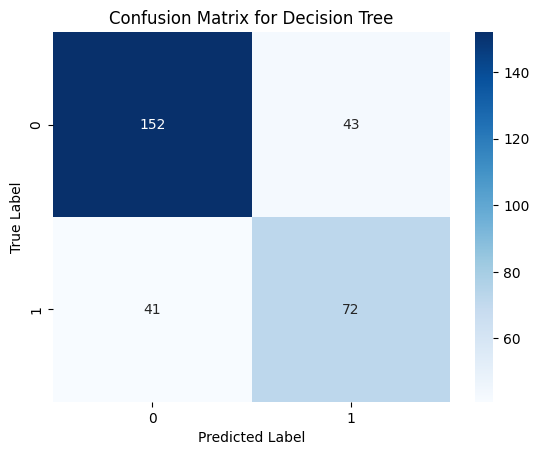

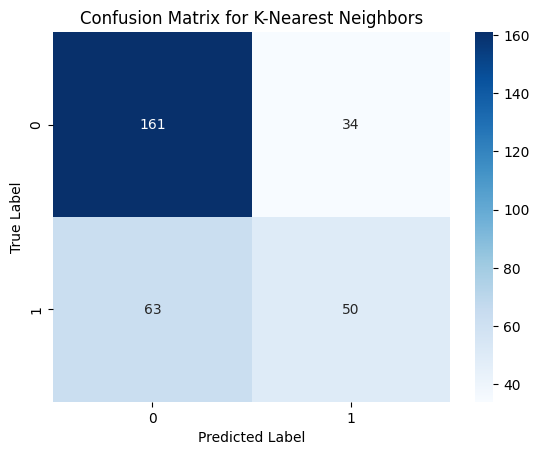

In [27]:
# Function to calculate and display the confusion matrix
def display_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    return cm

# Logistic Regression with best hyperparameters
best_logistic_model = LogisticRegression(C=0.01, penalty='l2', solver='liblinear', random_state=42)
best_logistic_model.fit(X_train, y_train)

# Decision Tree with best hyperparameters
best_decision_tree_model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=2, random_state=42)
best_decision_tree_model.fit(X_train, y_train)

# KNN with best hyperparameters
best_knn_model = KNeighborsClassifier(n_neighbors=9, p=1)
best_knn_model.fit(X_train, y_train)

# Display confusion matrices
cm_logistic = display_confusion_matrix(best_logistic_model, X_test, y_test, 'Logistic Regression')
cm_decision_tree = display_confusion_matrix(best_decision_tree_model, X_test, y_test, 'Decision Tree')
cm_knn = display_confusion_matrix(best_knn_model, X_test, y_test, 'K-Nearest Neighbors')


In [28]:
# Function to calculate and display classification report
def display_classification_report(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=['Non-Diabetic', 'Diabetic'])
    print(f"Classification Report for {model_name}:\n{report}")

# Display classification reports
display_classification_report(best_logistic_model, X_test, y_test, 'Logistic Regression')
display_classification_report(best_decision_tree_model, X_test, y_test, 'Decision Tree')
display_classification_report(best_knn_model, X_test, y_test, 'K-Nearest Neighbors')


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

Non-Diabetic       0.70      0.86      0.77       195
    Diabetic       0.61      0.38      0.47       113

    accuracy                           0.68       308
   macro avg       0.66      0.62      0.62       308
weighted avg       0.67      0.68      0.66       308

Classification Report for Decision Tree:
              precision    recall  f1-score   support

Non-Diabetic       0.79      0.78      0.78       195
    Diabetic       0.63      0.64      0.63       113

    accuracy                           0.73       308
   macro avg       0.71      0.71      0.71       308
weighted avg       0.73      0.73      0.73       308

Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

Non-Diabetic       0.72      0.83      0.77       195
    Diabetic       0.60      0.44      0.51       113

    accuracy                           0.69    

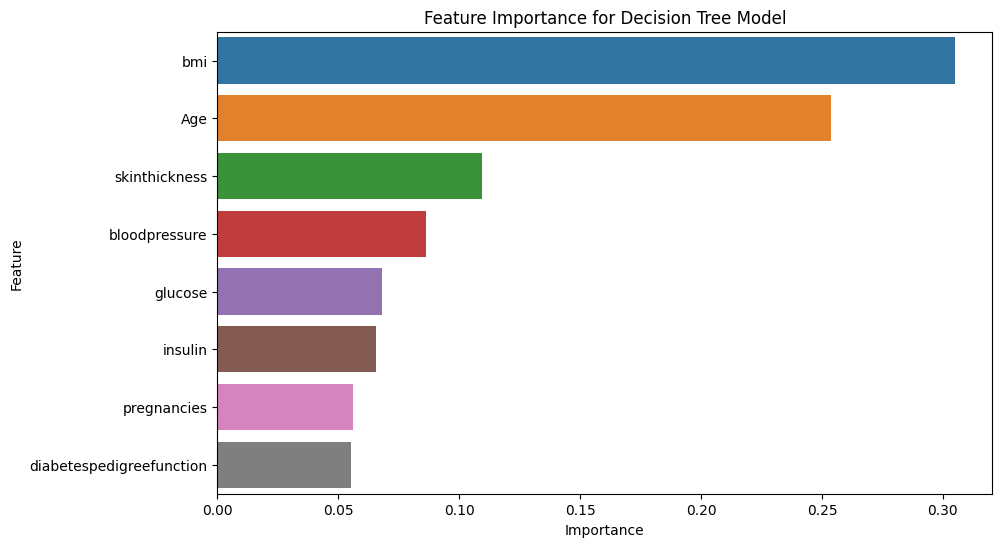

,Feature,Importance
2,bmi,0.305226
0,Age,0.253873
7,skinthickness,0.109603
5,bloodpressure,0.086266
4,glucose,0.068152
3,insulin,0.065770
1,pregnancies,0.055975
6,diabetespedigreefunction,0.055134


In [29]:
# Extract feature importances
feature_importances = best_decision_tree_model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by the importances
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance for Decision Tree Model')
plt.show()

feature_importance_df
